In [1]:
import os
from os.path import basename,dirname,join
import glob
import numpy as np
import pandas as pd
import geopandas as gpd

import flopy

import matplotlib.pyplot as plt
# import plotly #allows interactive plotting
# import contextily as ctx # back ground maps

# import rasterio
import shapely
from shapely.ops import linemerge
from shapely.geometry import LineString, Point, shape, mapping
import fiona


In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)

gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel/'
proj_dir = gwfm_dir+'Stream_seepage/'
dat_dir = proj_dir+'Stream_level_data/'

In [3]:
sfr_dir = gwfm_dir+'SFR_data/'

In [4]:
model_ws = proj_dir+'data'


# Stream XS data

In [6]:
params = pd.read_csv(model_ws+'/instream_sensor_params.csv',comment='#',engine='python')
params['id_num'] = params.Sensor.str.extract(pat=r'(\d+)').astype(float)
rm = params[params.Type=='Level']
rm_sp = gpd.GeoDataFrame(rm, geometry=gpd.points_from_xy(rm.Longitude,rm.Latitude))
rm_sp.crs = 'epsg:4326'
rm_sp = rm_sp.to_crs('epsg:32610')

rm_teichert = rm_sp[rm_sp.id_num>3]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\ajcalder/Box/research_cosumnes/GWFlowModel/Stream_seepage/data/instream_sensor_params.csv'

In [ ]:
# XS are every 100 m
xs_all = pd.read_csv(dat_dir+'XS_point_elevations.csv',index_col=0)
xs_all = gpd.GeoDataFrame(xs_all,geometry = gpd.points_from_xy(xs_all.Easting,xs_all.Northing), crs='epsg:32610')

# pivot based on XS number and save only elevation in z_m

xs_all_df = pd.read_csv(dat_dir+'Elevation_by_XS_number_meters.csv',index_col=0)
xs_all_df = xs_all_df.dropna(axis=0,how='any')

In [ ]:
fig, ax =plt.subplots(figsize=(6,6))
# USGS. USImagery, USImageryTopo, USTopo; Esri. WorldImagery, WorldTopoMap
# ctx.add_basemap(ax=ax, source=ctx.providers.Esri.WorldImagery, crs='epsg:26910', attribution=False)


xs_all.plot('z_m', markersize=0.2,legend=True,ax=ax,alpha=0.7)

rm_teichert.plot('Sensor',ax=ax,legend=True,marker='x')


In [ ]:
xs_all_df.plot()
plt.legend(ncol=4, loc=(1,0.01), title='XS Number')


## Simplify from 200 to 8 pt XS

In [ ]:
from shapely.geometry import LineString
i = 0
# Number of cross sections
numxs = int(len(xs_all_df.columns))
# i is the cross-section number
lp = pd.DataFrame(np.linspace(1,int(numxs),int(numxs)))
lp['geometry'] = LineString([(0,0),(0,1)])

for i in np.arange(0,numxs): #numxs
    # Number of points in each cross section
    numl = np.sum(pd.notna(xs_all_df.iloc[:,i]))
    # Create empty array to fill with coordinates
    lines = np.zeros((numl,2))
    # j is the number of points in each individual cross-section
    lm = LineString(list(zip(xs_all_df.index.values, xs_all_df.iloc[:,i].values)))
    tol = 0.6
    deltol = 0.01
    count = 0
    lms = LineString(lm).simplify(tolerance = tol)
    while len(list(lms.coords))>10:
        lms = LineString(lm).simplify(tolerance = tol)
        tol += deltol
        count += 1
    lp.geometry.iloc[int(i)] = LineString(lms)

In [ ]:
XS8pt = pd.DataFrame(np.zeros((numxs*8, 3)), columns=['xs_num','dist_from_right_m','z_m'])
XS8pt.xs_num = np.repeat(np.arange(0,numxs), 8)

# lpg = gpd.GeoDataFrame(lp[:])
xscoords = np.zeros((8, numxs))
filler = np.zeros(2)
filler[:] = np.nan
for i in np.arange(0, numxs):
    coordtemp = np.array(list(lp.geometry.iloc[i].coords))
    coordtemp = coordtemp[~np.isnan(coordtemp[:,0])]
    if len(coordtemp) > 8:
        coordtemp = coordtemp[1:]
    if len(coordtemp) >8:
        coordtemp = coordtemp[:-1]
    # reset distance from right to start at 0
    coordtemp[:,0] -= coordtemp[0,0]
#     while len(coordtemp)<10:
#         coordtemp = np.vstack((coordtemp,filler))
#     xscoords[:,i:i+2] = coordtemp
    XS8pt.loc[XS8pt.xs_num==i,['dist_from_right_m','z_m']] = coordtemp

    


In [ ]:
XS8pt.to_csv(proj_dir + '8pointXS_local.csv', index = False)
XS8pt = XS8pt.set_index('xs_num')


In [ ]:
# i=0
fig,ax=plt.subplots()
# np.array(list(lp.geometry.iloc[i].coords))
for i in np.arange(0,numxs):
    XS8pt.loc[XS8pt.index==i,:].plot(x='dist_from_right_m',y = 'z_m',ax=ax,label=str(i))
    print(XS8pt.loc[XS8pt.index==i,:].z_m.isna().sum(),end=' ')
    XS8pt.loc[XS8pt.index==i,:].z_m.isna().sum()

plt.legend(ncol=5,loc=(1,0.2))

# Model DIS
The transects were created every 100 m traveling down the NHD streamline. Model discretization should be 100 m with a new segment every 100m for 54 segments. The cross-sections have a transverse length of 200m.

In [ ]:
# xs_all_df
nrow=1
ncol = xs_all_df.columns.shape[0]
nlay=1

delr = 100 #longitudinal
delc= 200 # transverse
rotation=0

In [ ]:
events = pd.read_csv(dat_dir+'event_dates.csv',index_col=0,parse_dates=['start','end']).dropna(axis=0)

events['length'] = events.end-events.start
# events


Need sub daily steps to capture passage of flow between gages in 15 minutes.

In [ ]:
mb_15min = pd.read_csv(sfr_dir+'MB_15min_2010_10_01.csv',index_col='Datetime',parse_dates=['Datetime'])
# mb_15min = mb_15min[end_date:strt_date]

In [ ]:
# Transient -> might want to think about making SP1 steady
# end_date = pd.to_datetime('2020-01-22')
# strt_date = pd.to_datetime('2020-01-14')
# 5, 6, 8 have good peaks at MB
num = 5

strt_date = events.start[num]
end_date = events.end[num]


mb_15min_sim = mb_15min[strt_date:end_date]
# mb_15min_sim.index
mb_15min_sim.plot()

Removing the steady state period caused higher error in the first two stress periods, but then was fine. Spd 1 75% Spd 2 7% to near 0 after.

In [ ]:
# 15 minute stress periods with 5 min steps?

dates = pd.date_range(strt_date, end_date, freq = '15min')

# The number of periods is the number of dates 
# nper = len(dates)+1

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
# For new version each period has a length of 15 minutes
# perlen = np.ones(nper) # original with quick runtime
# perlen = np.append([1], np.full(nper-1, 15)) # correct version should be 15 minute periods

nper = len(dates) # try without SS period, the few pre storm events act as burn in
perlen = np.full(nper, 15) # no steady state period
nstp = 3*np.ones(nper)

# Reduce the number of timesteps to decrease run time
# 5 minute timessteps
# nstp = np.append(np.ones(1),3*np.ones(nper-1))


# Steady or transient periods
steady = np.zeros(nper)
# steady[0] = 1 # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()


In [ ]:
# the model ran 770 periods in 3 minutes then I went to adjust period length from 1 to 15 and re-wrote the DIS file
# which seemed to change the run in a way that caused a lot of error
# I updated the perlen to 15 and then corrected the SFR package to have the correct tab file input timing then
# the model ran quickly with no issues

In [ ]:
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'MODFLOW-NWT.exe', 
#                           version = 'mfnwt', model_ws=model_ws)


# save data to Box because model run size will be small
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mfnwt', 
                          version = 'mfnwt', model_ws=model_ws)
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 2, # in minutes because of SFR
                               rotation=rotation, 
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)


In [28]:
# write modelgrid to get updated row and col numbers specific to the child grid
# m.modelgrid.write_shapefile(gwfm_dir+'/DIS_data/streambed_seepage/1D_grid/1D_grid.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/streambed_seepage/1D_grid/1D_grid.shp')
# grid_p.crs = 'epsg:32610'
# convert to 0 based
grid_p[['node','row','column']] -=1

In [29]:
top = np.reshape(xs_all.dissolve('xs_num','max').z_m.values, (nrow,ncol))

bot = top - 30 # interested in unsaturated zone (~20m, 65 ft thick)
bot[0,:] = pd.Series(bot[0,:]).rolling(5, center=True).mean().ffill().bfill().values


m.dis.top = top
m.dis.botm = bot

In [30]:
m.dis.write_file()

# SFR
 XS data was sampled every 100 m going downstream
 THTS, THTI, EPS are activated ISFROPT = 2,3
 UHC (unsat hydraulic conductivity) is activated when ISFROPT = 3 (unsat zone active and specify UHC)
 
SFR2: NSTRM NSS NSFRPAR NPARSEG CONST DLEAK ISTCB1 ISTCB2 {ISFROPT} {NSTRAIL} {ISUZN} {NSFRSETS} {IRTFLG} {NUMTIM} {WEIGHT}{FLWTOL}
DFW: NSEG NRCH CONST ISTCB1 ISTCB2 ISFROPT
 
SFR2: KRCH IRCH JRCH ISEG IREACH RCHLEN STRTOP SLOPE STRTHICK STRHC1 THTS THTI EPS UHC  
DFW:  KRCH IRCH JRCH ISEG IREACH RCHLEN STRTOP SLOPE STRTHICK UHC THTS THTI THTR  
I can make flopy cheat to write the DFW file by replacing EPS with THTR and specifying ISFROPT = 2, and STRHC1 replaces UHC 

Once dfw is written out, I need to switch ISFROPT from 2 to 1, and delete NSTRAIL (20) and NSFRSETS (30)

In [96]:
# specify DFW or SFR2 (UZF) output
DFW = False

In [97]:
# create summary of XS for creating SFR inputs
# XSg = xs_all.dissolve('xs_num', 'mean')
XSg = xs_all.loc[(xs_all.dist_from_right_m==100).values,:].set_index('xs_num') # use center point for assigning segment data
XSg['iseg'] = XSg.index + 1 # add the segment that corresponds to each cross section

In [98]:
# There is one reach for each cell that a river crosses
NSTRM = -len(XSg)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = len(XSg) 
# NSS = 2
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 60 # mannings constant for SI units, 1.0 for seconds, 86400 for days, 60 for minutes
# real value equal to the tolerance of stream depth used in
# computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55
# writes out stream depth, width, conductance, gradient when cell by cell
# budget is specified and istcb2 is the unit folder
ISTCB2 = 54
# isfropt = 1 is no unsat flow
# specifies whether unsat flow beneath stream or not, isfropt 2 has properties read for each reach, isfropt 3 also has UHC
# read for each reach, isfropt 4 has properties read for each segment (no UHC), 5 reads for each segment with UHC
ISFROPT = 3
# nstrail (int), number of trailing weave increments used to represent a trailing wave, used to represent a decrease 
# in the surface infiltration rate. Can be increased to improve mass balance, values between 10-20 work well with error 
# beneath streams ranging between 0.001 and 0.01 percent, default is 10 (only when isfropt >1)
NSTRAIL = 20
# isuzn (int) tells max number of vertical cells used to define the unsaturated zone beneath a stream reach (default is 1)
ISUZN = 1
#nsfrsets (int) is max number of different sets of trailing waves (used to allocate arrays), a value of 30 is sufficient for problems
# where stream depth varies often, value doesn't effect run time (default is 30)
NSFRSETS = 30
# IRTFLG (int) indicates whether transient streamflow routing is active, must be specified if NSTRM <0. If IRTFLG >0 then
# flow will be routed with the kinematic-wave equations, otherwise it should be 0 (only for MF2005), default is 1
IRTFLG = 1
# numtim (int) is number of sub time steps used to route streamflow. Streamflow time step = MF Time step / NUMTIM. 
# Default is 2, only when IRTFLG >0
NUMTIM = 5
# weight (float) is a weighting factor used to calculate change in channel storage 0.5 - 1 (default of 0.75) 
WEIGHT = 0.75
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
# 0.00003 m3/s = 2.592 m3/day
# a flow tolerance of 1 cfs is equal to 2446.57 m3/day
# if my units are in m3/day then flwtol should be in m3/day
FLWTOL = 0.00003*60

extension = 'sfr'
if DFW == True:
    ISFROPT = 2
    extension = 'dfw'

sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, nstrail = NSTRAIL, isuzn = ISUZN, irtflg = IRTFLG, 
                          numtim = NUMTIM, weight = WEIGHT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=True,
                                tabfiles_dict={1: {'numval': nper, 'inuit': 56}},
                               extension = extension)

In [99]:
# Add option block at the top of the sfr input file for tabfiles
tab_option = flopy.utils.OptionBlock(options_line = ' reachinput transroute tabfiles 1 ' + str(nper), package = sfr, block = True)
sfr.options = tab_option
# sfr.options

In [100]:
# xs_sfr = grid_sfr.set_index('reach')
# # set all reaches to start as segment 1 which will be changed iteratively based on the number of cross-sections
# xs_sfr['iseg'] = 1
# # add a column reach_new that will be changed iteratively as the segment number is changed
# xs_sfr['reach_new'] = xs_sfr.index
# # xs_sfr

XSg['reach'] = 1
XSg['column'] = XSg.index
XSg['row'] = 0
XSg['layer'] = 0

XSg['node'] = grid_p.set_index(['row','column']).loc[list(zip(XSg.row,XSg.column))].node.values


In [101]:
rm_poly = rm_teichert.copy()
# buffer sensor points for joining
rm_poly.geometry = rm_poly.geometry.buffer(50)
# correspond XS to sensors
XSg = gpd.sjoin(XSg, rm_poly, how='left', op='intersects')
# keep only sensors in final
rm_xs = XSg.dropna(subset=['Sensor'])

# use MCC to set downstream parameters
mcc_sp = rm_sp[rm_sp.Sensor=='MCC']
# set last XS to be filled with values upstream from McConnell gage even though not directly used
XSg.loc[XSg.index.max(), mcc_sp.columns]  = mcc_sp.values[0]

In [102]:
# save XSg structure for when iterating over parameters
sensor_dict = XSg[['iseg','reach','Sensor']].bfill()
sensor_dict.to_csv(join(model_ws,'sensor_xs_dict.csv'))

<AxesSubplot:xlabel='xs_num'>

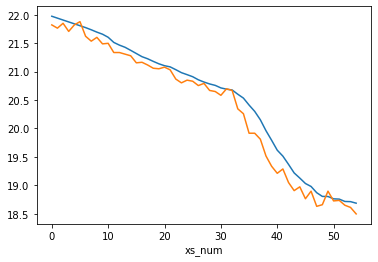

In [103]:
# find minimum value in XS related to thalweg
XSg['z_m_min'] = xs_all.dissolve('xs_num','min').z_m
#roling mean of 6 window centered removes any negative slope
XSg['z_m_min_cln'] = XSg.z_m_min.rolling(6,center=False).mean()

# calculate slope and fill NAs, fill slope with nearby
z_cln_diff = XSg.z_m_min_cln.diff().bfill()
XSg['slope'] = z_cln_diff.abs()/delr

# fix str bot so all is downward sloping
for i in np.arange(len(XSg)-1,-1,-1):
#     if XSg.z_m.values[i] >= XSg.z_m.values[i-1]:
#         XSg.z_m_min.values[i] = XSg.z_m_min.values[i-1] - XSg.slope.values[i]*delc
# fill NAs due to rolling mean
    if XSg.z_m_min_cln.isna()[i]:
        XSg.z_m_min_cln.values[i] = XSg.z_m_min_cln.values[i + 1] + XSg.slope.values[i]*delr

        
# plot, large spike in top elevation causes discontinuity
# plt.plot(m.dis.top.array[0,:])
# plt.plot(m.dis.botm.array[0,0,:])

XSg.z_m_min_cln.plot()
XSg.z_m_min.plot()
# XSg.slope.plot(secondary_y = True)

In [104]:
# fill upstream with parameters from sensors
XSg[['strhc1', 'strthick', 'thts','thti','eps','uhc','thtr']] = XSg[['strhc1', 'strthick', 'thts','thti','eps','uhc','thtr']].bfill()

In [105]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr.reach_data.node = XSg.node
sfr.reach_data.k = XSg.layer.astype(int)
sfr.reach_data.i = XSg.row
sfr.reach_data.j = XSg.column
sfr.reach_data.iseg = XSg.iseg
sfr.reach_data.ireach = XSg.reach
sfr.reach_data.rchlen = delr
sfr.reach_data.strtop = XSg.z_m_min_cln
sfr.reach_data.slope = XSg.slope
 # a guess of 2 meters thick streambed was appropriate
sfr.reach_data.strthick = XSg.strthick

sfr.reach_data.strhc1 = XSg.strhc1/(24*60) # start with low conductivity 10 m/day (sandy muddish) to m/min

# UZF parameters
sfr.reach_data.thts = XSg.thts
sfr.reach_data.thti = XSg.thti # partially saturated initially
sfr.reach_data.eps = XSg.eps
sfr.reach_data.uhc = XSg.uhc/(24*60)

if DFW == True:
    # use eps/strhc1 to write out THTR/uhc when DFW is written
    sfr.reach_data.eps = XSg.thtr
    sfr.reach_data.strhc1 = XSg.uhc/(24*60) # start with low conductivity 10 m/day (sandy muddish) to m/min


In [106]:
mb4rl = pd.read_csv(sfr_dir+'/michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')


In [107]:

sfr_seg = sfr.segment_data[0].copy()

sfr_seg.nseg = np.arange(1,NSS+1)

sfr_seg.icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
# sfr_seg.icalc = 4 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
# sfr_seg.icalc[0] = 4 # use stage, discharge width method for Michigan Bar (nseg=1)
# sfr_seg.nstrpts[sfr_seg.icalc==4] = 50 # specify number of points used for flow calcs

sfr_seg.outseg = sfr_seg.nseg+1 # the outsegment will typically be the next segment in the sequence
sfr_seg.iupseg = 0 # iupseg is zero for no diversion


In [108]:
# set a flow into segment 1 for the steady state model run
sfr_seg.flow[0] = 2.834*60. # m3/min, originally 15 m3/s
# set the values for ET, runoff and PPT to 0 as the inflow will be small relative to the flow in the river
sfr_seg.runoff = 0.0
sfr_seg.etsw = 0.0
sfr_seg.pptsw = 0.0

# Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
# RoughCH is only specified for icalc = 1 or 2
sfr_seg.roughch[(sfr_seg.icalc==1) | (sfr_seg.icalc==2)] = 0.048
# ROUGHBK is only specified for icalc = 2
sfr_seg.roughbk[(sfr_seg.icalc==2) | (sfr_seg.icalc==5)] = 0.083# higher due to vegetation

In [121]:
sfr_seg

rec.array([( 1, 2,  2, 0, 0, 0, 170.04, 0., 0., 0., 0.048, 0.083, 0., 0., 0., 0., 0.00069444, 1., 21.974174, 100., 1., 0.25, 0.15, 3., 0.00069444, 0.00069444, 1., 21.974174, 100., 1., 0.25, 0.15, 3., 0.00069444),
           ( 2, 2,  3, 0, 0, 0,   0.  , 0., 0., 0., 0.048, 0.083, 0., 0., 0., 0., 0.00069444, 1., 21.940838, 100., 1., 0.25, 0.15, 3., 0.00069444, 0.00069444, 1., 21.940838, 100., 1., 0.25, 0.15, 3., 0.00069444),
           ( 3, 2,  4, 0, 0, 0,   0.  , 0., 0., 0., 0.048, 0.083, 0., 0., 0., 0., 0.00069444, 1., 21.9075  , 100., 1., 0.25, 0.15, 3., 0.00069444, 0.00069444, 1., 21.9075  , 100., 1., 0.25, 0.15, 3., 0.00069444),
           ( 4, 2,  5, 0, 0, 0,   0.  , 0., 0., 0., 0.048, 0.083, 0., 0., 0., 0., 0.00069444, 1., 21.874163, 100., 1., 0.25, 0.15, 3., 0.00069444, 0.00069444, 1., 21.874163, 100., 1., 0.25, 0.15, 3., 0.00069444),
           ( 5, 2,  6, 0, 0, 0,   0.  , 0., 0., 0., 0.048, 0.083, 0., 0., 0., 0., 0.00069444, 1., 21.840824, 100., 1., 0.25, 0.15, 3., 0.00069444, 0

In [109]:
sfr.segment_data[0] = sfr_seg

In [110]:
# Pull out data for upstream and downstream reach of each segment
XSup = XSg.dissolve('iseg','first')
XSdn = XSg.dissolve('iseg','last')

# Need to return to later and remove hard coding
# These are getting used for initial guesses
# Read in first stress period when ICALC = 1 or 2 and ISFROPT is 5
# Dataset 6b
sfr.segment_data[0].hcond1 = XSup.strhc1/(24*60)
sfr.segment_data[0].thickm1 = XSup.strthick
sfr.segment_data[0].elevup = XSup.z_m_min_cln.values
sfr.segment_data[0].width1 = 100
sfr.segment_data[0].depth1 = 1
sfr.segment_data[0].thts1 = XSup.thts
sfr.segment_data[0].thti1 = XSup.thti
sfr.segment_data[0].eps1 = XSup.eps
sfr.segment_data[0].uhc1 = XSup.uhc/(24*60)

# Dataset 6c
sfr.segment_data[0].hcond2 = XSdn.strhc1/(24*60)
sfr.segment_data[0].thickm2 = XSdn.strthick
sfr.segment_data[0].elevdn = XSdn.z_m_min_cln.values
sfr.segment_data[0].width2 = 100
sfr.segment_data[0].depth2 = 1
sfr.segment_data[0].thts2 = XSdn.thts
sfr.segment_data[0].thti2 = XSdn.thti
sfr.segment_data[0].eps2 = XSdn.eps
sfr.segment_data[0].uhc2 = XSdn.uhc/(24*60)


In [111]:
print('NA with elev at 199: ', xs_all_df.isna().sum().sum(), '. NA without 199: ',xs_all_df.iloc[:-1].isna().sum().sum())
# Shanafield said that you can have more than 8 pts in a XS
# XS8pt = xs_all_df.iloc[:-1]

NA with elev at 199:  0 . NA without 199:  0


Need to reduce to 8 point XS for method as is or pre - calculate flow, depth and width relation with mannings which may be better since I can decide when to use different mannings n  
GWF2SFR7FLW - 8-point cross-section module

# Mannings equation
The assumption of levee setback is that as the setback distance increases so does the wetted xs perimeter which increases the hydraulic radius (there is more roughness impacting the water) so the velocity will be lower. This analysis is independent of varying geology, and river reach under the assumption that any recontoured reach would undergo restoration resulting in similar reach rougnesses of the floodplain (small bushes, trees). And it will assume the existing average bed slope of the lower Cosumnes river applies.  

$ Q = VA = (\frac{1.00}{n}) A  {R}^{2/3} \sqrt{S} $  
$ R = \frac{A}{Wp}$  
hydraulic radius r is XS area divided by wetted perimeter  
[Manning's eqn reference](http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Manning_s_Equation.htm)  
Avg manning's n for in channel is 0.048  - clean, winding, some pools and shoals, but some weeds and stones, lower stages, more ineffective, slopes and sections
Floodplains have much broader range, due to variability in vegetation type: tall grass is 0.035 but dense willows is 0.15  
[Manning's n reference](http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Mannings_n_Tables.htm)  

Slope for Cosumnes could be considered the 0.0006 which is the mean for all reaches

In [112]:
# def mannings(xs_elevs, n=0.048, S= 0.001):
#     """ Given a depth (m) , XS (m by m), n and S returns discharge in cubic meters per second"""
#     Q = np.zeros(50)
#     width = np.zeros(50)
#     V = np.zeros(50)
#     d_tab = np.geomspace(0.1, xs_elevs.max()-xs_elevs.min(),50)

#     for x, d in enumerate(d_tab):
#         # d = np.linspace(0, xs_elevs.max()-xs_elevs.min(),50)

#         wse = xs_elevs.min()+d
#         xs_wet = wse - xs_elevs


#         xs_wet[xs_wet < 0] = 0
#         width[x] = (xs_wet>0).sum()
#         # multiply by 1m to get area and sum for area
#         A = xs_wet.sum() * 1
#         # calculate wetted perimeter
#         xy = xs_elevs[wse - xs_elevs > 0]
#         Wp = np.sum(np.sqrt(np.diff(xy.values)**2 + np.diff(xy.index.values)**2))
#         Q[x] = (np.sqrt(S)/n) * (A**(5/3)) / (Wp**(2/3))
#         V[x] = Q[x]/A

#     return(Q, d_tab, width, V)

# channel_flow = {0: {1:[] }}
# # flow must increase
# # ICALC4 can't have unsaturated zone flow
# for i in XSg.index:
#     # output is cubic meters per second
#     # model needs cubic meters per minute
#     FLOWTAB, DPTHTAB, WDTHTAB, V = mannings(XS8pt.iloc[:,i], n= 0.025, S = XSg.slope[i])
#     channel_flow[0][i+1] = [FLOWTAB*60, DPTHTAB, WDTHTAB]
    
# # DPTHTAB = mb4rl.gage_height_va.values
# # WDTHTAB = mb4rl.chan_width.values
# # sfr.channel_flow_data = channel_flow

In [113]:
# i=0
# FLOWTAB, DPTHTAB, WDTHTAB, V = mannings(XS8pt.iloc[:,i], n= 0.025, S = XSg.slope[i])
# plt.plot(DPTHTAB, FLOWTAB/(0.3048**3))
# plt.show()

# d_tab

In [115]:
# Change column name to float type for easier referencing in iteration
# XS8pt.columns = XS8pt.columns.astype('float')
# XS8pt
# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(1,len(XSg)+1)}  }

xsnum = 1
for k in XSg.index:
        XCPT = XS8pt.loc[k].dist_from_right_m.values # old XS8pt[k].index
        ZCPT = XS8pt.loc[k].z_m.values # old XS8pt[k].values
        ZCPT_min = np.min(ZCPT)
        ZCPT-= ZCPT_min
        sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
        xsnum += 1



In [116]:
# FLOWTAB = mb4rl.discharge_va.values
# DPTHTAB = mb4rl.gage_height_va.values
# WDTHTAB = mb4rl.chan_width.values
# sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

In [118]:
# sfr.check()
sfr.write_file()

In [ ]:
# For the tab files the left column is time (in model units) and the right column is flow (model units)
# Time is days, flow is cubic meters per day
# USGS presents flow in cfs (cubic feet per second)
# inflow = pd.read_csv(sfr_dir+'MB_daily_flow_cfs_2010_2019.csv', index_col = 'datetime', parse_dates = True)
# filter out data between the stress period dates
# inflow = inflow.loc[strt_date:end_date]

# covnert flow from cubic feet per second to cubic meters per day
inflow = mb_15min_sim.copy()
inflow['flow_cmm'] = inflow.Discharge_cfs * (60*(0.3048**3))

# get time of each flow starting
time_mins = (inflow.index- inflow.index[0]).values.astype(float)/(60*1E9)+1
# time_flow = np.vstack((np.arange(1,len(inflow.flow_cmm)+1),inflow.flow_cmm)) # by days
time_flow = np.vstack((time_mins, inflow.flow_cmm))

time_flow = np.transpose(time_flow)
# add a first row to account for the steady state stress period
# median instead of mean because of too much influence from large values
time_flow = np.row_stack(([0, inflow.flow_cmm.median()], time_flow))

np.savetxt(model_ws+'/MF.tab',time_flow, delimiter = '\t')

In [87]:
if DFW== True:
    os.rename(model_ws+'/'+m.name+'.sfr', model_ws+'/'+m.name+'.dfw')
    print('SFR renamed to DFW')

In [ ]:
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'tab',unitnumber = 56)

# Model discretization with SFR

In [ ]:
ibound = np.ones((nlay,nrow,ncol))
# to maintain gw flow gradient that mimics ground surface slope shanafield used a CHD at up and down stream
ibound[:,:,0] = -1
ibound[:,:,-1] = -1

#originally started heads 5 m below stream bottom but gw mound started connection in middle reaches
strt = np.reshape(XSg.z_m_min.values, (nrow,ncol)) - 10 # start heads below the stream bottom



In [ ]:
# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
# add option: STOPERROR 0.01 to reduce percent error when OWHM stops model
# if solver criteria are not met, the model will continue if model percent error is less than stoperror
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt) #, stoper = 0.01

In [ ]:
# may have to manually add since it seems to overwrite
# allows model to continue even if convergence fails
# bas.options = bas.options +' NO_FAILED_CONVERGENCE_STOP'
# bas.write_file()

In [ ]:
hk = np.zeros(m.dis.botm.shape)
hk[:,:,:] = 10
vka = 1
sy = np.zeros(m.dis.botm.shape)
sy[:,:,:] = 0.2
ss = np.zeros(m.dis.botm.shape)
ss[:,:,:] = 1E-4


In [ ]:
# layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
layvka = 1

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# laytyp = np.ones(nlay)  
# laytyp = np.zeros(nlay)
# try making first 10 layers convertible/ unconfined, model crashes trying to convert wet/dry
num_unconf = 1
laytyp = np.append(np.ones(num_unconf), np.zeros(nlay-num_unconf))

# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
laywet = np.zeros(len(laytyp))
# laywet[laytyp==1] = 1
laywet = 0 # flopy said laywet must be 0 for upw
#ipakcb = 55 means cell-by-cell budget is saved because it is non zero (default is 53)

# until upscaling is begun then vertical and horiz K are the same for TPROGS
gel = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, 
#                                ss = storativity, storagecoefficient=True, 
                               ss=ss, 
                               laytyp=laytyp, laywet = laywet, ipakcb=55)

# gel = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = hk, sy=sy, 
# #                                ss = storativity, storagecoefficient=True, 
#                                ss=ss, 
#                                laytyp=laytyp, laywet = laywet, ipakcb=55)

In [ ]:
gel.write_file()

# Gage outflow
Can set up files for each stream stage sensor or use the primary sfr/dfw out file
numgage is total number of gages  
gage_data (list, or array), includes 2 to 3 entries (LAKE -UNIT (OUTTYPE)) for each LAK entry  
4 entries (GAGESEG, GAGERCH, UNIT, OUTTYPE) for each SFR package entry  
OUTTYPE:
1 Default values plus depth, width, and flow at midpoint.  
2 Default values plus streambed conductance for the reach, head difference across streambed, and hydraulic gradient across streambed.  
4 All of the above  


In [ ]:

# values for Unit number and specify gage output type
rm_xs['unit'] = 200 + rm_xs.iseg
rm_xs['outtype'] = 4

# rm_xs.to_file(proj_dir+ 'rm_xs/rm_xs.shp')

In [ ]:
gage_data = rm_xs[['iseg','reach','unit', 'outtype']].values.tolist()
gage_file = 'MF.gage'
gag_out_files = 'MF_gage_' + rm_xs.iseg.astype(str) +'.go'
gag = flopy.modflow.ModflowGage(model=m,numgage= len(gage_data),gage_data=gage_data,
                                filenames =[gage_file]+gag_out_files.values.tolist())


In [ ]:
# gag.write_file()

# Output and Solver 

In [ ]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# For later model runs when all the data is needed to be saved
spd = { (j,0): ['save head'] for j in np.arange(0,nper,1)}

# get the first of each month to print the budget
month_intervals = (pd.date_range(strt_date,end_date, freq="MS")-strt_date).days

for j in month_intervals:
    spd[j,0] = ['save head','print budget']
    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

In [ ]:
oc.write_file()

In [ ]:
# Shanafield input for nWT
#  MODFLOW2005 NWT Input File

# HEADTOL FLUXTOL MAXITEROUT THICKFACT LINMETH IPRNWT IBOTAV OPTIONS [DBDTHETA] [DBDKAPPA] [DBDGAMMA] [MOMFACT] [BACKFLAG] [MAXBACKITER] [BACKTOL] [BACKREDUCE]
# 1.0E-3 0.01 5000 0.001  2  1 1 SPECIFIED 0.80 0.0001 0.000  0.10 0  20 2.0 0.6  linmeth=1 (GMRES); =2 (xmd)     
#[IACL][NORDER][LEVEL][NORTH][IREDSYS][RRCTOLS][IDROPTOL][EPSRN] [HCLOSEXMD][MXITERXMD]
# 2 0 1 2 0 0.0 1 1 1.0E-3 7 1.0e-4      100 2  2  1.0e-9  20  4       XMD (faster results--6.7 seconds) 


# 1.0e-4 5.0e-4 500 0.001  2  1 1 0.70 0.0001 0.000  0.00 0  20 2.0 0.6  linmeth=1 (GMRES); =2 (xmd)  
# 2 0 1 2 0 0.0 1 1 1.0E-3 7 1.0e-4     XMD (faster results--6.7 seconds)

#  MODFLOW2005 NWT Input File
# 1.0E-2 15.0 500 0.001  2  1 1 0.70 0.0001 0.000  0.00 0  20 2.0 0.6  linmeth=1 (GMRES); =2 (xmd)  
# 2 0 8 2 0 0.0 1 1 1.0E-3 7 1.0e-4     XMD (faster results--6.7 seconds)

In [ ]:
nwt = flopy.modflow.ModflowNwt(model = m, headtol=1E-4, fluxtol=500, maxiterout=200, thickfact=1e-05, 
                               linmeth=1, iprnwt=1, ibotav=0, options='Specified', Continue=False)
# continue = true causes issue with nwt read in
nwt_dict = nwt.__dict__
# nwt_dict
# nwt_dict['headtol'] = 1E-3
# nwt.__dict__ = nwt_dict
# nwt.__dict__
# nwt.write_file()

In [ ]:
# load in parameters used by margaret shanafield for DFW
nwt_ex = pd.read_csv(gwfm_dir+'Solvers/nwt_solver_input_from_dfw.csv', comment='#')
nwt_ex['nwt_vars'] = nwt_ex.NWT_setting.str.lower()
nwt_ex = nwt_ex.set_index('nwt_vars')
nwt_ex = nwt_ex.dropna(axis=1, how='all')
# nwt_ex.select_dtypes([float, int])

for v in nwt_ex.index.values:
    nwt_dict[v] = nwt_ex.loc[v,'First'].astype(nwt_ex.loc[v,'nwt_dtype'])

In [ ]:
# set stricter standards to stop non-converge in routchan
nwt_dict['fluxtol'] = 1E-4 
nwt_dict['headtol'] = 1E-4
# try increasing allowed iterations
# nwt_dict['maxbackiter'] = 100
# nwt_dict['maxitinner'] = 200
# this seems to be the culprit!!!!! was set to 7 which was where all iterations were stopping??
nwt_dict['mxiterxmd'] = 50

In [ ]:
# update NWT sovler parameters
nwt.__dict__ = nwt_dict

nwt.write_file()

In [ ]:
# nwt = flopy.modflow.ModflowNwt(model= m)
# thickfact: portion of cell thickness used for smoothly adjusting storage and conductance coefficients to zero (default is 1e-5)
# linmeth (linear method): 1 for GMRES and 2 for XMD (1 is default)
# iprnwt: flag whether additional info about solver convergence will be printed to the main listing file (default is 0)
# ibotav: flag whether corretion will be made to gw head relative to cell-bottom if surrounded by dry cells.
# 1 = corrections and  0 = no correction (default is 0)
# options: specify comlexity of solver. SIMPLE : default solver for linear models, MODERATE for moderately nonlinear models,
# COMPLEX for highly nonlinear models (default is COMPLEX)
# Continue: if model fails to converge during a time step it will continue to solve the next time step (default is False) 
# epsrn (XMD) is the drop tolerance for preconditioning (default is 1E-4)
# hclosexmd (XMD) head closure criteria for inner (linear) iterations (default 1e-4)
# headtol/flux tol are in m/day
# solver = flopy.modflow.ModflowNwt(model = m, headtol=1E-4, fluxtol=500, maxiterout=200, thickfact=1e-05, 
#                                linmeth=1, iprnwt=1, ibotav=0, options='SPECIFIED', Continue=True,
#                                maxbackiter=50, backtol=1.1, maxitinner=50, ilumethod=2, 
#                                levfill=5, stoptol=1e-10, msdr=15, iacl=2, norder=1, level=5, north=7, 
#                                iredsys=0, rrctols=0.0, idroptol=1, epsrn=0.0001, hclosexmd=0.0001, 
#                                mxiterxmd=50, extension='nwt', unitnumber=27)




In [ ]:
m.get_package_list()

In [ ]:
# sfr.check()
# sfr.write_file()
# m.dis.write_file()


In [ ]:
# m.write_input()

In [ ]:
# m.write_name_file()

# UCODE input
jif for gage output if using only absolute values (else need post-processor script to write file for jif)
jtf for updating STRHC1, etc

Sensitivity Analysis:  
Goal of SA is to run through all parameters for all segments to identify if parameters such as THTS, THTI, EPS.  
For SFR2 when ISFROPT = 3 then UHC is used instead of strhc1.  
For DFW, ISFROPT must equal 1 and formatting is slightly different  



In [88]:
m_ucode = flopy.modflow.Modflow.load('MF.nam', model_ws=model_ws, 
                                exe_name='mf-owhm', version='mf2005')


IndexError: list assignment index out of range

In [ ]:
# code for parameter estimation
sensor_dict = pd.read_csv(join(model_ws, 'sensor_xs_dict.csv'))
XS_params = sensor_dict.join(params.set_index('Sensor'), on='Sensor')
# base sfr params
sfr.reach_data.strthick = XS_params.strthick
sfr.reach_data.strhc1 = XS_params.strhc1/(24*60) # start with low conductivity 10 m/day (sandy muddish) to m/min
# UZF parameters
sfr.reach_data.thts = XS_params.thts
sfr.reach_data.thti = XS_params.thti # partially saturated initially
sfr.reach_data.eps = XS_params.eps
sfr.reach_data.uhc = XS_params.uhc/(24*60)
if DFW == True:
    # use eps/strhc1 to write out THTR/uhc when DFW is written
    sfr.reach_data.eps = XSg.thtr
    sfr.reach_data.strhc1 = XSg.uhc/(24*60) # start with low conductivity 10 m/day (sandy muddish) to m/min


## Pdata 

In [21]:
def get_magnitude(x):
    return(10.0**(np.log10(x).astype(int)))

def make_pdata(params):
    # melt parameter data and rename columns to fit UCODE format for .pdata
    pdata = params.set_index('Sensor')[['strthick','strhc1','thts','thti','eps','uhc']]
    pdata = pdata.melt(ignore_index=False)
    pdata['ParamName'] = pdata.variable + '_' + pdata.index.astype(str)
    # organize columns
    pdata = pdata[['variable','ParamName','value']]
    pdata = pdata.rename(columns={'variable':'GroupName','value':'StartValue'}).reset_index(drop=True)

    # default values for pdata input
    pdata['LowerValue'] = 1E-38
    pdata['UpperValue'] = 1E38

    # local adjustment based on typical parameter scaling (start value scaled by a range)
    # need to find a better rounding function
    grps = pdata.GroupName.isin(['strhc1','uhc'])
    pdata.loc[grps,'LowerValue'] = get_magnitude(pdata.loc[grps,'StartValue']) *1E-3
    pdata.loc[grps,'UpperValue'] = get_magnitude(pdata.loc[grps,'StartValue']) *1E3
    grps = pdata.GroupName.isin(['thts', 'thti'])
    pdata.loc[grps,'LowerValue'] = 1E-3
    pdata.loc[grps,'UpperValue'] = 1
    # double check eps range
    grps = pdata.GroupName.isin(['strthick','eps'])
    pdata.loc[grps,'LowerValue'] = 0.5
    pdata.loc[grps,'UpperValue'] = 5

    # assume constraints align with expected range
    pdata['Constrain'] = 'No'
    pdata['LowerConstraint'] = pdata.LowerValue
    pdata['UpperConstraint'] = pdata.UpperValue


    # left justify data so it is clean for writing to text file
    pdata = pdata.astype(str)
    for n in pdata.columns:
        pdata[n] = pdata[n].str.ljust(int(pdata[n].str.len().max()*1.2))
    return(pdata)
# pdata = make_pdata(params)
pdata = make_pdata(rm_teichert.drop(columns=['id_num','geometry']))

In [22]:
pdata


,GroupName,ParamName,StartValue,LowerValue,UpperValue,Constrain,LowerConstraint,UpperConstraint
0,strthick,strthick_RM4,1.0,0.5,5.0,No,0.5,5.0
1,strthick,strthick_RM5,1.0,0.5,5.0,No,0.5,5.0
2,strthick,strthick_RM6,1.0,0.5,5.0,No,0.5,5.0
3,strthick,strthick_RM7,1.0,0.5,5.0,No,0.5,5.0
4,strthick,strthick_RM8,1.0,0.5,5.0,No,0.5,5.0
5,strhc1,strhc1_RM4,1.0,0.001,1000.0,No,0.001,1000.0
6,strhc1,strhc1_RM5,1.0,0.001,1000.0,No,0.001,1000.0
7,strhc1,strhc1_RM6,1.0,0.001,1000.0,No,0.001,1000.0
8,strhc1,strhc1_RM7,1.0,0.001,1000.0,No,0.001,1000.0
9,strhc1,strhc1_RM8,1.0,0.001,1000.0,No,0.001,1000.0


In [23]:
pdata_header = 'BEGIN Parameter_Data Table\nNROW='+str(pdata.shape[0])+' NCOL=8 COLUMNLABELS\n'
import csv

with open(model_ws+'/MF_ucode.pdata', 'w',newline='') as f:
    f.write(pdata_header)
    # write pdata to model workspace
    pdata.to_csv(f, sep=' ', index=False, quoting=csv.QUOTE_NONE, escapechar=' ') # quoting=csv.QUOTE_NONE, escapechar=' '
    f.write('END Parameter_Data Table')

## Pgroup

In [24]:
#'GroupName Adjustable Transform MaxChange SenMethod  PerturbAmt'
pgroup =  pd.DataFrame(pdata.GroupName.unique(), columns=['GroupName'])
# pgroup = pdata.set_index(['GroupName']).drop(columns=['ParamName','Constrain']).astype(float)
# pgroup = pgroup.groupby('GroupName').mean()
# pgroup['Adjustable'] = 'no'
pgroup['Transform'] = 'no'
pgroup['MaxChange'] = 1
pgroup['SenMethod'] = 1
pgroup['PerturbAmt'] = 0.01
pgroup

,GroupName,Transform,MaxChange,SenMethod,PerturbAmt
0,strthick,no,1,1,0.01
1,strhc1,no,1,1,0.01
2,thts,no,1,1,0.01
3,thti,no,1,1,0.01
4,eps,no,1,1,0.01
5,uhc,no,1,1,0.01


In [25]:
pgroup_header = 'BEGIN Parameter_Group Table\nNROW='+str(pdata.shape[0])+' NCOL=8 COLUMNLABELS\n'
import csv

with open(model_ws+'/MF_ucode.pgroup', 'w',newline='') as f:
    f.write(pgroup_header)
    # write pdata to model workspace
    pgroup.to_csv(f, sep=' ', index=False, quoting=csv.QUOTE_NONE, escapechar=' ') # quoting=csv.QUOTE_NONE, escapechar=' '
    f.write('END Parameter_Group Table')

## JTF for parameters

In [173]:
pcols = params.columns[~params.columns.isin(['Sensor','Type','Latitude','Longitude'])]

In [183]:
pout = params.set_index('Sensor').copy()
for n in pcols:
    pout[n] = '@'+(n+'_'+pout.index.astype(str)).str.ljust(20)+'@'
with open(model_ws+'/instream_sensor_params.csv.jtf', 'w',newline='') as f:
    f.write('jtf @\n')
    pout.to_csv(f,index=True, mode="a") 
    

In [ ]:
ucode_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/ucode_utilities'
if ucode_fxn_dir not in sys.path:
    sys.path.append(ucode_fxn_dir)
# sys.path
import ucode_input

from importlib import reload
# importlib.reload
reload(ucode_input)

In [ ]:
hobout = pd.read_csv(m.model_ws+'/MF.hob.out',delimiter = r'\s+')

# here std deviation represents the actual value one expects
# for a well the accuracy is 0.01 ft at best based on measuring tape scale
all_obs['Statistic'] = 0.01
all_obs['StatFlag'] = 'SD'
# locations with significant difference between RPE GSE and the DEM should have additional uncertainty included
all_obs['Statistic'] += np.round(np.abs(all_obs.dem_wlm_gse),4)

hobout_in = hobout.join(all_obs.set_index('obs_nam')[['Statistic','StatFlag']],on=['OBSERVATION NAME'])
# temporary fix for misjoin for single observation HOB nodes
hobout_in.loc[hobout_in.Statistic.isna(),'Statistic'] = 0.01 
hobout_in['StatFlag'] = 'SD'

ucode_input.write_hob_jif_dat(model_ws, hobout_in, statflag=True)

In [ ]:
# data for obs table
mcc_d = pd.read_csv(sfr_dir+'MCC_flow_obs_all.csv', index_col='DATE TIME', parse_dates=True)

mcc_d = mcc_d[(mcc_d.index>=strt_date)&(mcc_d.index<=end_date)]
# ObsName ObsValue Statistic StatFlag GroupName
mcc_d['ObsName'] = ('mcc_'+pd.Series(np.arange(0,len(mcc_d)).astype(str)).str.zfill(5)).values
# make sure units are flow in m^3/day
mcc_d = mcc_d.rename(columns={'flow_cmd':'ObsValue'})

cols_out = ['ObsName','ObsValue','Statistic','StatFlag','GroupName']

header = 'BEGIN Observation_Data Table\n'+\
    'NROW= '+str(len(mcc_d))+' NCOL= 5 COLUMNLABELS\n'+\
    ' '.join(cols_out)

footer = 'End Observation_Data'
# get array of just strings
flow_arr = mcc_d[cols_out].values
# pull out observed value and name of obs
np.savetxt(model_ws+'/flow_obs_table.dat', flow_arr,
           fmt='%s', header = header, footer = footer, comments = '' )

# for gage file JIFs need to specify which flows are used by specify the observation name
# for the correct row (time) and filling the rest with a dummy variable (Cab used dum)

In [ ]:
gagenam = model_ws+'/MF.gage1.go'
gage = pd.read_csv(gagenam,skiprows=1, delimiter = r'\s+', engine='python')
# clean issue with column name read in
cols = gage.columns[1:]
gage = gage.dropna(axis=1)
gage.columns = cols
# set datetime for joining with flow obs data
gage['dt'] = strt_date + (gage.Time-1).astype('timedelta64[D]')
gage = gage.set_index('dt').resample('D').mean()
gage_jif = gage[['Time','Flow']].join(mcc_d)
# if I leave Nan values then ucode gets upset, Cab used the filler dum which I think Ucode identifies
gage_jif.loc[gage_jif.ObsName.isna(),'ObsName'] = 'dum'

In [ ]:
# def write_flw_jif(model_ws, gagout):
#     # skip 2 rows, use 3rd column values for 1345 values for std MF gage out file
header = 'jif @\nStandardFile 2 3 '+str(len(gage_jif))
# header = 'jif @\n'+'StandardFile  1  1  '+str(len(obsoutnames))
# obsoutnames.to_file(m.model_ws+'/MF.hob.out.jif', delimiter = '\s+', index = )
np.savetxt(model_ws+'/MF.gage1.go.jif', gage_jif.ObsName.values,
           fmt='%s', delimiter = r'\s+',header = header, comments = '')

In [ ]:
# Parallel

In [ ]:
n_nodes = ucode_input.get_n_nodes(13)

In [ ]:
# 2400 seconds is about 40 minutes which is avg run time
# may need to extend upward to 3 hours (10800) for slow runs
ucode_input.write_parallel(model_ws, n_nodes,2400) 

In [ ]:
# copy mf files except cbc and hds
mf_files = pd.Series(glob.glob(m.model_ws+'/MF.*'))
mf_files = mf_files[~mf_files.str.contains('cbc|hds').values].tolist()
jtfs = glob.glob(m.model_ws+'/*.jtf')
run = glob.glob(m.model_ws+'/*py*')

files = mf_files+jtfs+run
files = glob.glob(m.model_ws+'/*.jtf')

In [ ]:
# when dealing with larger data sets, it may be worthwhile using parallel subprocess
import shutil, os


for n in np.arange(0, n_nodes).astype(str):
    folder = '/r'+ n.zfill(3)+'/'
    os.makedirs(m.model_ws+folder,exist_ok=True)
    for f in files:
        shutil.copy(f, m.model_ws+folder)

In [ ]:
# replace oc file with simplified version that only prints the budget monthly
f = glob.glob(m.model_ws+'/MF_parallel.oc')[0]

for n in np.arange(0, n_nodes).astype(str):
    folder = '/r'+ n.zfill(3)+'/'
    os.makedirs(m.model_ws+folder,exist_ok=True)
    shutil.copy(f, m.model_ws+folder+'/MF.oc')

In [ ]:
import shutil, os

# write out just the updated python write file
write_file = glob.glob(model_ws+'/*.py')
for n in np.arange(0,n_nodes).astype(str):
    folder = '/r'+ n.zfill(3)
    shutil.copy(write_file[0], model_ws+folder)